In [10]:
from typing import Generator, Mapping, Tuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
import optax
import tensorflow_datasets as tfds

from jax.tree_util import tree_flatten, tree_unflatten

import seaborn as sns
import matplotlib.pyplot as plt

## Model

In [2]:
Batch = Mapping[str, np.ndarray]


def net_fn(batch: Batch) -> jnp.ndarray:
  """Standard LeNet-300-100 MLP network."""
  x = batch["image"].astype(jnp.float32) / 255.
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(300), jax.nn.relu,
      hk.Linear(100), jax.nn.relu,
      hk.Linear(10),
  ])
  return mlp(x)


def net_fn_cnn(batch: jnp.ndarray) -> jnp.ndarray:
  """Standard LeNet-300-100 MLP network."""
  x = batch["image"].astype(jnp.float32) / 255.
  cnn = hk.Sequential([
      hk.Conv2D(24,5),
      hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
      hk.Conv2D(48,5),
      hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
      hk.Flatten(),
      hk.Linear(10),
  ])
  return cnn(x)


def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Generator[Batch, None, None]:
  """Loads the dataset as a generator of batches."""
  ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

# Make the network and optimiser.
net = hk.without_apply_rng(hk.transform(net_fn_cnn))
opt = optax.adam(1e-3)

# Training loss (cross-entropy).
def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(batch["label"], 10)

    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]

    return softmax_xent + 1e-4 * l2_loss

# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
    predictions = net.apply(params, batch)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == batch["label"])

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
    """Learning rule (stochastic gradient descent)."""
    grads = jax.grad(loss)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation (cf. https://doi.org/10.1137/0330046)
@jax.jit
def ema_update(params, avg_params):
    return optax.incremental_update(params, avg_params, step_size=0.001)

## Train

In [ ]:
# Make datasets.
train = load_dataset("train", is_training=True, batch_size=1000)
train_eval = load_dataset("train", is_training=False, batch_size=10000)
test_eval = load_dataset("test", is_training=False, batch_size=10000)

In [10]:
# Initialize network and optimiser; note we draw an input to get shapes.
params = avg_params = net.init(jax.random.PRNGKey(42), next(train))
opt_state = opt.init(params)

# Train/eval loop.
for step in range(10001):
    if step % 1000 == 0:
        # Periodically evaluate classification accuracy on train & test sets.
        train_accuracy = accuracy(avg_params, next(train_eval))
        test_accuracy = accuracy(avg_params, next(test_eval))
        train_accuracy, test_accuracy = jax.device_get(
          (train_accuracy, test_accuracy))
        print(f"[Step {step}] Train / Test accuracy: "
            f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

    # Do SGD on a batch of training examples.
    params, opt_state = update(params, opt_state, next(train))
    avg_params = ema_update(params, avg_params)


[Step 0] Train / Test accuracy: 0.094 / 0.095.
[Step 1000] Train / Test accuracy: 0.985 / 0.982.
[Step 2000] Train / Test accuracy: 0.996 / 0.989.
[Step 3000] Train / Test accuracy: 0.999 / 0.990.
[Step 4000] Train / Test accuracy: 1.000 / 0.990.
[Step 5000] Train / Test accuracy: 1.000 / 0.990.
[Step 6000] Train / Test accuracy: 1.000 / 0.990.
[Step 7000] Train / Test accuracy: 1.000 / 0.989.
[Step 8000] Train / Test accuracy: 1.000 / 0.989.
[Step 9000] Train / Test accuracy: 1.000 / 0.990.
[Step 10000] Train / Test accuracy: 1.000 / 0.989.


## NTK

In [3]:
# Make datasets.
train = load_dataset("train", is_training=True, batch_size=1000)
train_eval = load_dataset("train", is_training=False, batch_size=10000)
test_eval = load_dataset("test", is_training=False, batch_size=10000)

In [4]:
def ptwise_loss(params, batch):
    batch['image'] = jnp.expand_dims(batch['image'],0)
    #batch['label'] = jnp.expand_dims(batch['label'],0)
    return loss(params,batch)

ptwise_grad = jax.vmap(jax.grad(ptwise_loss),in_axes=(None,{"image":0,"label":0}),out_axes=0)

def ravel_pytree(pytree):
    leaves, treedef = tree_flatten(grads)
    batch_size = leaves[0].shape[0]
    return jnp.concatenate([jnp.reshape(elt,(batch_size,-1)) for elt in leaves],axis=1)

In [5]:
train_eval = load_dataset("train", is_training=False, batch_size=1000)
batch = next(train_eval)

params = net.init(jax.random.PRNGKey(42), next(train))
grads = ptwise_grad(params,batch)
features = ravel_pytree(grads)

## Estimate Expected Distance between Classes

In [7]:
seq = hk.PRNGSequence(42)

def avg_sim(features,labels,classes,rng_seq,num_iters=1000):
    
    n_classes = len(classes)
    counts = np.zeros(shape=(n_classes,n_classes))
    totals = np.zeros(shape=(n_classes,n_classes))
    
    batch_size = features.shape[0]
    
    # Randomly sample two points
    
    for _ in range(num_iters):
    
        [i,j]  = random.choice(next(rng_seq),np.arange(batch_size),shape=(2,),replace=False)
        
        prod = jnp.dot(features[i],features[j])
        
        indi = classes.index(labels[i])
        indj = classes.index(labels[j])
        
        totals[indi,indj] += prod
        counts[indi,indj] += 1
    
    totals = (totals + totals.T)/2
    counts = (counts + counts.T)/2
    

    return totals/counts


classes = list(range(10))
labels = batch['label']

sim = avg_sim(features,labels,classes,seq)

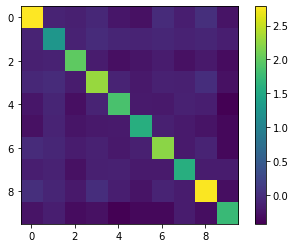

In [15]:
plt.imshow(sim)
plt.colorbar()